In [3]:
import math
import numpy as np
import pandas as pd
from analytic_wfm import peakdetect_spline
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline, UnivariateSpline
from sklearn.neighbors import KernelDensity
from FlowCytometryTools import FCMeasurement
from statsmodels.distributions.empirical_distribution import ECDF

In [4]:
fcs_dir = 'C:/Users/lzoeckler/Desktop/fcs_risk_study'

In [28]:
test = FCMeasurement(ID='', datafile='{}/G01 GRM-4030_D14-1.fcs'.format(fcs_dir))
fcs_data = test.data
fcs_channels = test.channels

In [29]:
print(len(fcs_data), 'observations')
print(type(fcs_data))
test.channels

30000 observations
<class 'pandas.core.frame.DataFrame'>


,$PnB,$PnR,$PnN,$PnE,$PnS
Channel Number,,,,,
1,32,16777216,FSC-A,"[0, 0]",FSC-A
2,32,16777216,SSC-A,"[0, 0]",SSC-A
3,32,16777216,FL1-A,"[0, 0]",FL1-A
4,32,16777216,FL2-A,"[0, 0]",FL2-A
5,32,16777216,FL3-A,"[0, 0]",FL3-A
6,32,16777216,FL4-A,"[0, 0]",FL4-A
7,32,16777216,FSC-H,"[0, 0]",FSC-H
8,32,16777216,SSC-H,"[0, 0]",SSC-H
9,32,16777216,FL1-H,"[0, 0]",FL1-H


In [30]:
fcs_data.head()

,FSC-A,SSC-A,FL1-A,FL2-A,FL3-A,FL4-A,FSC-H,SSC-H,FL1-H,FL2-H,FL3-H,FL4-H,Width,Time
0,336613.0,34474.0,11175.0,3972.0,2358.0,1908.0,380950.0,34761.0,9126.0,3068.0,1927.0,5922.0,87.0,139.0
1,78109.0,16600.0,15204.0,3518.0,4780.0,6014.0,90499.0,18356.0,10888.0,3118.0,3349.0,6513.0,56.0,139.0
2,279918.0,34298.0,10496.0,2143.0,1342.0,0.0,298002.0,33368.0,9126.0,1772.0,1722.0,5308.0,89.0,139.0
3,345933.0,17971.0,12271.0,3151.0,3589.0,9185.0,403081.0,20565.0,11139.0,4095.0,2247.0,6010.0,88.0,139.0
4,181339.0,18449.0,10793.0,3337.0,5102.0,7823.0,208344.0,18568.0,8514.0,2305.0,2580.0,6433.0,70.0,139.0


In [31]:
test = fcs_data.loc[fcs_data['FL1-H'] > 0]
test = test[['FSC-H', 'SSC-H', 'FL1-H']]
test['FL1-H'] = test['FL1-H'].apply(math.log)
test.head()

,FSC-H,SSC-H,FL1-H
0,380950.0,34761.0,9.118883
1,90499.0,18356.0,9.295417
2,298002.0,33368.0,9.118883
3,403081.0,20565.0,9.318208
4,208344.0,18568.0,9.049467


In [32]:
FSC_ecdf = ECDF(test['FSC-H'])
test['FSC-H'] = FSC_ecdf(test['FSC-H'])
SSC_ecdf = ECDF(test['SSC-H'])
test['SSC-H'] = SSC_ecdf(test['SSC-H'])
test.head()

,FSC-H,SSC-H,FL1-H
0,0.987432,0.777478,9.118883
1,0.040771,0.300130,9.295417
2,0.900690,0.752042,9.118883
3,0.992999,0.382772,9.318208
4,0.479915,0.309198,9.049467


In [33]:
fsc_filt = (.4, .95)
ssc_filt = (.05, .6)
sub_filter1 = (test['FSC-H'] >= fsc_filt[0])
sub_filter2 = (test['FSC-H'] <= fsc_filt[1])
sub_test = test.loc[sub_filter1 & sub_filter2]
ssc_filter = (test['SSC-H'] >= ssc_filt[0]) & (test['SSC-H'] <= ssc_filt[1])
sub_test = sub_test.loc[ssc_filter]
sub_test.head()

,FSC-H,SSC-H,FL1-H
4,0.479915,0.309198,9.049467
7,0.557389,0.492216,9.079206
8,0.902424,0.179018,9.247925
9,0.821749,0.450312,9.123693
14,0.729606,0.519219,8.889446


In [34]:
fl1h = sub_test['FL1-H'].as_matrix()
density = gaussian_kde(fl1h).evaluate(fl1h)
sub_test['density'] = density
d_sum = sub_test['density'].max()
sub_test['freq'] = sub_test['density'].apply(lambda x: x / d_sum)
fl1h_max = sub_test['FL1-H'].max()
sub_test['intensity'] = sub_test['FL1-H'].apply(lambda x: 100 * (x / fl1h_max))
sub_test.drop_duplicates(['FL1-H', 'density', 'freq', 'intensity'],
                         inplace=True)
sub_test.sort_values('intensity', inplace=True)
sub_test.head()

C:\Users\lzoeckler\miniconda3\envs\G6PD\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


,FSC-H,SSC-H,FL1-H,density,freq,intensity
8415,0.674034,0.067940,6.566672,0.000942,0.000598,66.401878
19065,0.597593,0.086975,6.778785,0.001734,0.001100,68.546749
23648,0.862486,0.181118,6.815640,0.002053,0.001302,68.919426
919,0.548021,0.386672,6.874198,0.001686,0.001069,69.511567
15903,0.477281,0.179318,6.952729,0.001182,0.000750,70.305660


In [35]:
intense = sub_test['intensity'].values
dense = sub_test['density'].values
freq = sub_test['freq'].values

In [36]:
smooth_spline = CubicSpline(sub_test['intensity'], sub_test['freq'])
spline_derivative = smooth_spline.derivative()
den_x = smooth_spline(sub_test['density'])
intense_x = smooth_spline(sub_test['intensity'])
freq_x = smooth_spline(sub_test['freq'])

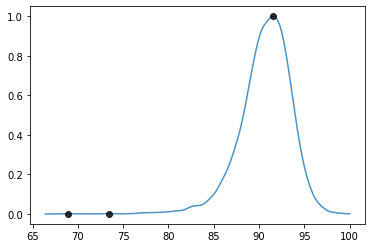

In [37]:
peaks1, properties1 = find_peaks(freq)
x_vals = intense[peaks1]
y_vals = freq[peaks1]
plt.plot(intense, freq, alpha=0.8)
plt.plot(x_vals, y_vals, "o", color='k', alpha=0.8)

In [38]:
x_vals

array([68.91942614, 73.38959349, 91.54808057])

In [39]:
y_vals

array([0.00130185, 0.00239894, 1.        ])

In [40]:
peaks_data = sub_test.loc[sub_test['freq'].isin(y_vals)]
peaks_data = peaks_data.loc[peaks_data['intensity'].isin(x_vals)]
peaks_data = peaks_data.loc[peaks_data['freq'] > .3]
peaks_data = peaks_data.loc[peaks_data['intensity'] < 99]
peaks_data.head()

,FSC-H,SSC-H,FL1-H,density,freq,intensity
13859,0.585559,0.554389,9.053453,1.576698,1.0,91.548081


In [41]:
max_int = max(peaks_data['intensity'])
len_condition = len(peaks_data.loc[peaks_data['intensity'] > max_int - 10])
if len_condition == len(peaks_data):
    maxima = [max_int]
else:
    min_int = min(peaks_data['intensity'])
    maxima = [min_int, max_int]
    maxima_mean = sum(maxima) / len(maxima)
    abs_condition = abs(sub_test['intensity'] - maxima_mean)
    min_condition = min(abs_condition)
    mean_data = sub_test.loc[abs_condition == min_condition]
    meanidx = max(mean_data['intensity'])

In [42]:
maxima

[91.54808056913362]

In [43]:
if len(maxima) == 2:
    upper_freq = sub_test.loc[sub_test['intensity'] >= meanidx,
                              'freq']
    bc_percent = round((100 * (1 - upper_freq.sum())), 1)
elif (len(maxima) == 1) & (maxima[0] > 75):
    exp_log_maxima = math.exp(math.log(maxima[0]) - .15)
    abs_condition = abs(sub_test['intensity'] - exp_log_maxima)
    min_condition = min(abs_condition)
    exp_log_data = sub_test.loc[abs_condition == min_condition]
    exp_log_val = max(exp_log_data['intensity'])
    exp_log_freq = exp_log_data.loc[
        exp_log_data['intensity'] >= exp_log_val, 'freq']
    bc_percent = float(round((100 * (1 - exp_log_freq.sum())), 1))
elif (len(maxima) == 1) & (maxima[0] <= 75):
    exp_log_maxima = math.exp(math.log(maxima[0]) + .15)
    abs_condition = abs(sub_test['intensity'] - exp_log_maxima)
    min_condition = min(abs_condition)
    exp_log_data = sub_test.loc[abs_condition == min_condition]
    exp_log_val = max(exp_log_data['intensity'])
    exp_log_freq = exp_log_data.loc[
        exp_log_data['intensity'] >= exp_log_val, 'freq']
    bc_percent = round((100 * (1 - exp_log_freq.sum())), 1)
else:
    raise ValueError('Something went wrong!')

In [44]:
bc_percent

99.2

In [45]:
mainp = ''.join('{}, '.format(x) for x in maxima)

In [46]:
mainp

'91.54808056913362, '

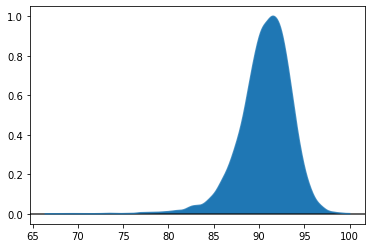

In [47]:
plt.axhline(color='k', alpha=0.8)
plt.plot(intense, freq, alpha=0.8)
plt.fill_between(intense, 0, freq)

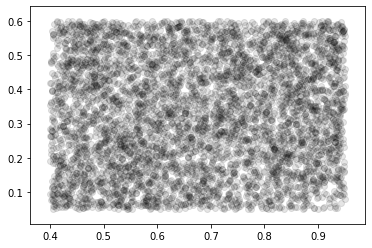

In [48]:
plt.scatter(sub_test['FSC-H'], sub_test['SSC-H'], alpha=0.1, color='k')

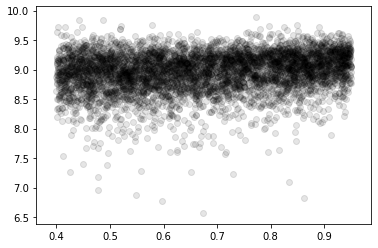

In [49]:
plt.scatter(sub_test['FSC-H'], sub_test['FL1-H'], alpha=0.1, color='k')

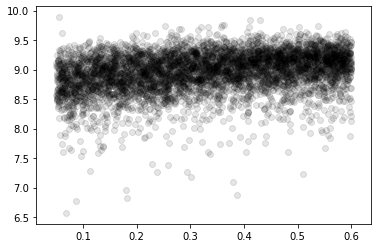

In [50]:
plt.scatter(sub_test['SSC-H'], sub_test['FL1-H'], alpha=0.1, color='k')